In [1]:
# Import necessary components 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from matplotlib import pyplot
from math import sqrt
from numpy import mean
from numpy import std
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [2]:
# Import SARS and COVID csv files
# Only import 'date' and 'cumulative_cases' columns
canada_sars = pd.read_csv('./data/sars_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])
canada_covid = pd.read_csv('./data/covid_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])

# Given input data and how many training data it would be used,
# Split the input data into train and test data
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# Convert into data
data_train = canada_sars.values
data_test = canada_covid.values

In [3]:
# Defining a few functions that is needed
# These functions are used for RMSE calculation as well as walk-forward validation

# Shifting data to in order for an 'one-step forecast'
def shift_data(data, n_in = 1, n_out = 1):
    dataframe = pd.DataFrame(data)
    col = list()

    # Separate into two col, with one that is shifted forward
    for i in range(n_in, 0, -1):
        col.append(dataframe.shift(i))

    for i in range(0, n_out):
        col.append(dataframe.shift(-i))

    # Brings all result together and drop rows with NaN
    result = pd.concat(col, axis=1)
    result.dropna(inplace=True)

    return result.values

# Returns the RMSE (Root Mean Square Error) given the actual and predicted value
def calculate_error(actual, predicted):
	print('Actual: ' + f'{actual[len(actual) - 1][0]}')
	print('Predicted: %.0f' % (predicted[len(predicted) - 1][0]))

	pyplot.plot(actual, label='Actual')
	pyplot.plot(predicted, label='Predicted')
	pyplot.legend()
	pyplot.show()

	return sqrt(mean_squared_error(actual, predicted))

# This function does walk forward validation
# This is when the modal makes a one step forecast for each observation
def walk_forward_validation(test, train, config):
    prediction = list()

    # Fit model
    model = fit_model(train, config)

    # Set history
    history = [x for x in train]

    for i in range(len(test)):
        # Fit model and make a forecast for the history
        y_hat = predict_model(model, history, config)

        # Stores the forecast into a list
        prediction.append(y_hat)
        history.append(test[i])
    
    # Estimate error
    error = calculate_error(test, prediction)
    print('Error: ' + '%.3f' % error)

    return error

# Repeated evaluation
def repeat_evaluation(test, train, config, n_repeats):
    score_list = list()

    for i in range(n_repeats):
        print('\nIteration: %.0f' % (i + 1))
        score_list.append(walk_forward_validation(test, train, config));

    return score_list

# Summarize model
def summarize(name, score_list):
    score_m, score_std = mean(score_list), std(score_list)
    print('\n%s: %.3f RMSE (+/- %.3f)' % (name, score_m, score_std))

    # Create box and whisker plot
    pyplot.boxplot(score_list)
    pyplot.show()


Iteration: 1
Actual: 68848
Predicted: 66861


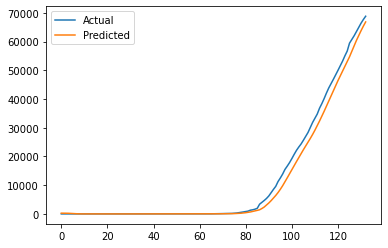

Error: 2155.216

Iteration: 2
Actual: 68848
Predicted: 66270


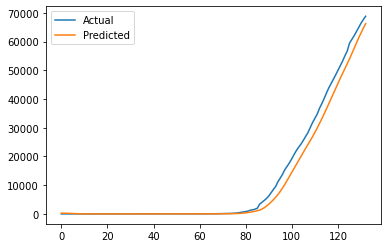

Error: 2608.464

Iteration: 3
Actual: 68848
Predicted: 66272


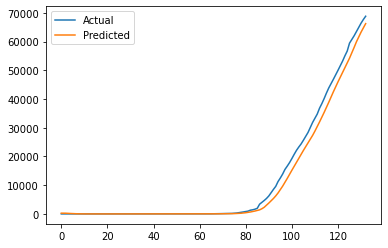

Error: 2345.687

Iteration: 4
Actual: 68848
Predicted: 66134


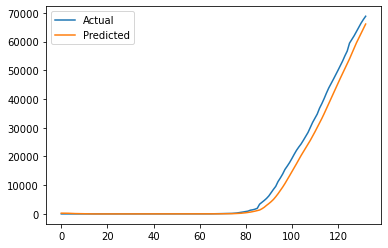

Error: 2553.020

Iteration: 5
Actual: 68848
Predicted: 66182


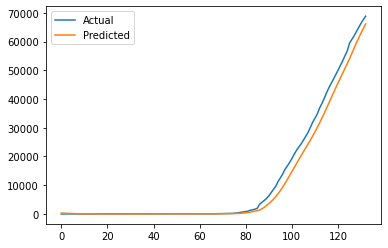

Error: 2540.703

Iteration: 6
Actual: 68848
Predicted: 66611


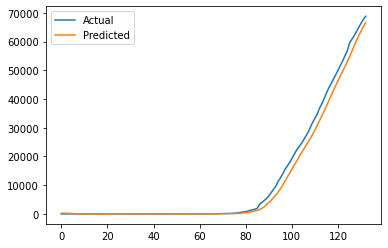

Error: 2133.995

Iteration: 7
Actual: 68848
Predicted: 66511


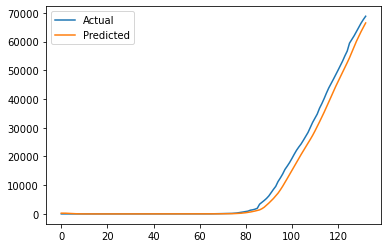

Error: 2324.986

Iteration: 8
Actual: 68848
Predicted: 66805


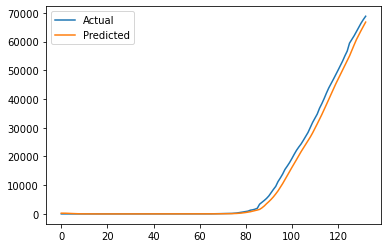

Error: 1863.792

Iteration: 9
Actual: 68848
Predicted: 66590


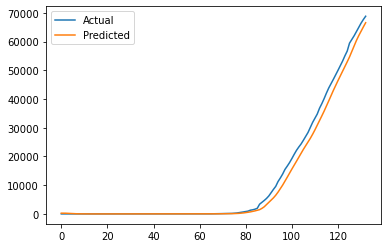

Error: 2117.086

Iteration: 10
Actual: 68848
Predicted: 66082


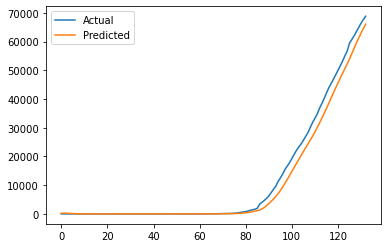

Error: 2529.661

CNN: 2317.261 RMSE (+/- 232.774)


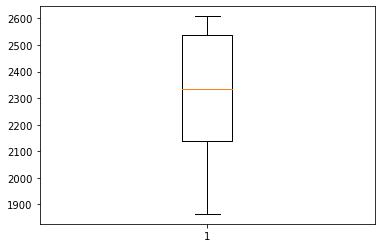

In [4]:
# Building the Convolutional Neural Network Model using the following configuration
# n_input: The number of observations to use
# n_filters: The number of parallel filters
# n_kernel: The number of steps in each in/out sequence
# n_epochs: The number of times to expose the model
# n_batch: The number of samples within an epoch after the weights are updated

# Define and then fit the model
# Given the training data, and configuration, this function fits a model
def fit_model(train, config):
    n_input, n_filters, n_kernel, n_epochs, n_batch = config

    # Separate training data in to X and y
    data = shift_data(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    # Define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # Fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    return model

# Predict the model
# Given a model, the history, and configuration, this function predicts a model
def predict_model(model, history, config):
    n_input, _, _, _, _ = config

    # Prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))

    # Predict model
    y_hat = model.predict(x_input, verbose=0)

    return y_hat[0]

# After defining the two functions needed to fit and predict the model, define the configuration
config = [12, 256, 3, 100, 100]

# Create and fit model
# Error is calculate throughout the entire prediction period
score_list = repeat_evaluation(data_test, data_train, config, 10)
summarize('CNN', score_list)